In [1]:
import os
from PIL import Image

## Read In Data and Featurization

Parses every age folder in the ./face_age directory, using the PIL library to read in each image. Convert each image into a two demensional array of grayscale pixel value representations. It is then resizes to be a 50 pixel by 50 pixel array, so constrain the number of features. Then we convert to a numpy array and flatten. We then rotate each image by a random degree value between -22 and 22, to add more data to the set and account for different head positions.  

In [2]:
X = []
Y = []
raw_images = []
width = 100
height = 100
INPUT_CLASSES_DIR = 'face_age/'

import numpy as np
import random

for folder_name,_,filenames in os.walk(INPUT_CLASSES_DIR):
    count = 0
    if folder_name !="face_age/":
        if int(folder_name[-3:]) < 70:
            for file in filenames:
                if count < 30:
                    file_path = folder_name +"/"+ file
                    image = Image.open(file_path).convert('L').resize((width, height))
                    X.append(np.array(image).flatten())
                    raw_images.append(image)
                    Y.append(int(folder_name[-3:]))
                    count += 1

                    # add 3 random rotations of the image with a range of -15 to 15 degrees
                    for i in range(2):
                        degrees = random.randint(-22, 22);
                        rotated = image.rotate(degrees)
                        raw_images.append(rotated)
                        X.append(np.array(rotated).flatten())
                        Y.append(int(folder_name[-3:]))


    else:
        pass

Randomly select some raw images to plot

<PIL.Image.Image image mode=L size=20x20 at 0x12F30834E50>


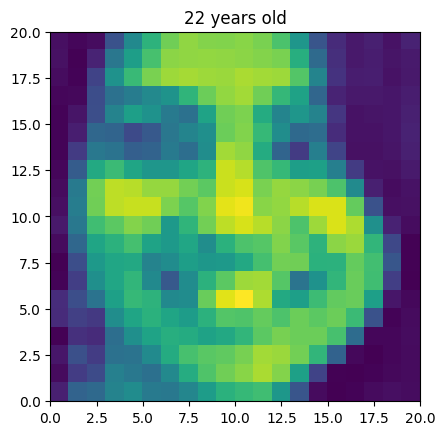

<PIL.Image.Image image mode=L size=20x20 at 0x12F2E164670>


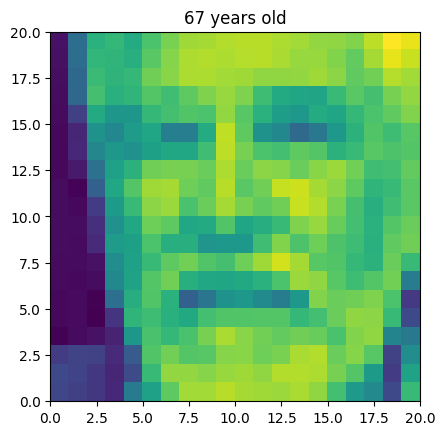

<PIL.Image.Image image mode=L size=20x20 at 0x12F2E0CEB60>


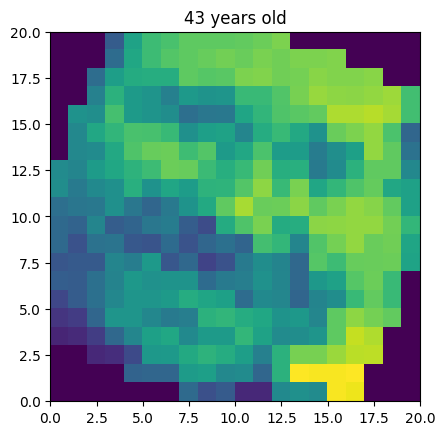

<PIL.Image.Image image mode=L size=20x20 at 0x12F3084A0B0>


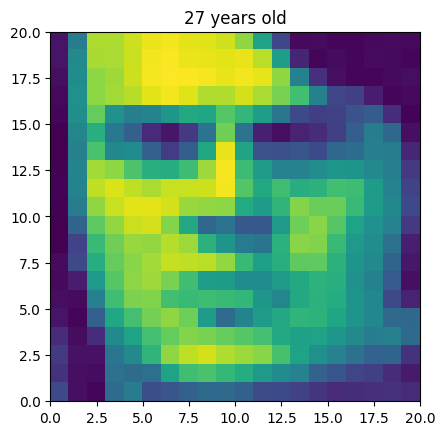

<PIL.Image.Image image mode=L size=20x20 at 0x12F30837A90>


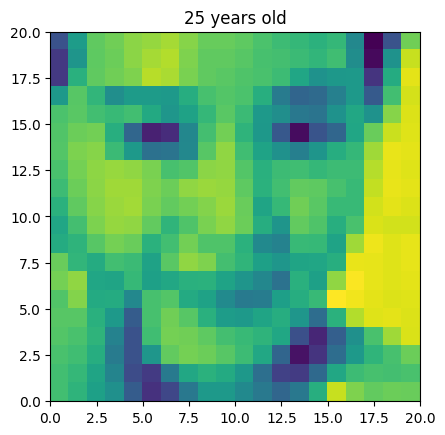

In [3]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(0,5):
    rand = random.randint(0, len(X))
    im = raw_images[rand]
    print(im)
    label = Y[rand]
    fig, ax = plt.subplots()
    im = ax.imshow(im, extent=[0, 20, 0, 20])
    plt.title(str(label) + " years old")
    plt.show()

#### Convert features and labels into a dataframe

In [4]:
import pandas as pd

df = pd.DataFrame(X)
df['age'] = Y

df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,age
0,127,-115,-108,-103,-98,-94,-90,-87,-84,-78,...,125,-75,-63,-78,-88,-73,-55,-53,-46,1
1,0,0,0,0,0,0,0,-70,-67,-67,...,67,98,0,0,0,0,0,0,0,1
2,0,0,0,0,0,-90,-87,-84,-78,-74,...,63,125,-75,-63,0,0,0,0,0,1
3,-19,-50,-51,-46,-54,-58,-62,-63,-63,-60,...,-105,-112,-121,111,108,-128,88,103,-120,1
4,0,0,-24,-61,-60,-55,-65,-72,-75,-63,...,-107,-118,126,107,125,107,99,0,0,1


Print shape of dataframe, showing (rows, columns), where the rows is the number of samples and the columns is number of features + targets.

In [5]:
print(df.shape)

(6198, 401)


## SVM

Train a Support Vector Machine model with a random subset of the data as the training set. Trained 3 times, on three separate C values (regularization paramter) to see the effect on accuracy. 

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


def plot_effect_of_C(data):

    means = []
    Cs = []

    for d in data:
        means.append(d['our_test_acc'])
        Cs.append(d['C (regularization)'])


    plt.plot(range(len(Cs)),means)
    plt.xticks(range(len(Cs)), Cs)
    plt.title('hyperparameter vs accuracy (within 10 years on either side)')
    plt.xlabel('hyperparameter C')
    plt.ylabel('accuracy')
    plt.show()

def train_test_SVM(features, target):
    data_rows = []
    total_score = 0

    C =  [.8, .9, 1, 1.1, 1.2, 1.3]
    iters = len(C)
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target)

        model = SVC(max_iter=10000, C = C[i], kernel = 'rbf').fit(X_train, y_train)

        # Prediction accuracies and distributions in each age group
        actual = model.predict(X_test)
        expected = y_test.array
        correct = 0

        dictScores = {'0-5': 0, '6-10': 0, '11-15': 0, '16-25': 0, '+25': 0}
        for index, age in enumerate(actual):
            # How well the model perfroms with a 10 year gap
            if abs(age - expected[index]) < 10:
                correct += 1

            diff = abs(age - expected[index])

            if diff <= 5:
                dictScores['0-5']+=1
            elif diff <= 10:
                dictScores['6-10']+=1
            elif diff <= 15:
                dictScores['11-15']+=1
            elif diff <= 25:
                dictScores['16-25']+=1
            else:
                dictScores['+25']+=1


        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "C (regularization)": C[i],
            "train_acc": train_acc,
            "test_acc": test_acc,
            "our_test_acc": correct/len(X_test)
        })

        print(dictScores)

    plot_effect_of_C(data_rows)
    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

   

In [7]:
target = df['age']
df2 = df.drop(columns=['age'])
features = df2

{'0-5': 601, '6-10': 205, '11-15': 176, '16-25': 223, '+25': 345}
{'0-5': 637, '6-10': 194, '11-15': 153, '16-25': 233, '+25': 333}
{'0-5': 664, '6-10': 203, '11-15': 152, '16-25': 209, '+25': 322}
{'0-5': 680, '6-10': 189, '11-15': 160, '16-25': 179, '+25': 342}
{'0-5': 727, '6-10': 153, '11-15': 148, '16-25': 201, '+25': 321}
{'0-5': 729, '6-10': 201, '11-15': 142, '16-25': 199, '+25': 279}


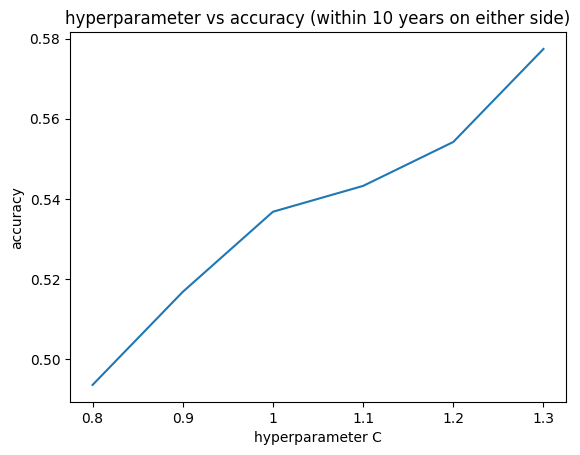

average score 0.2688172043010753 
    C (regularization)  train_acc  test_acc  our_test_acc
0                 0.8   0.745697  0.213548      0.493548
1                 0.9   0.797332  0.228387      0.516774
2                 1.0   0.843158  0.271613      0.536774
3                 1.1   0.879088  0.281290      0.543226
4                 1.2   0.903830  0.305806      0.554194
5                 1.3   0.922762  0.312258      0.577419


In [17]:
train_test_SVM(features, target)

## Logistic Regression

In [9]:

def train_test_logistic_regressor(features, target):

    data_rows = []
    total_score = 0
    iters = 1
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=.6)
        model = LogisticRegression(max_iter=10000, C = 1.5).fit(X_train, y_train)


        # Predict accuracies and distributions in each age group
        actual = model.predict(X_test)
        expected = y_test.array
        correct = 0

        dictScores = { '0-5': 0, '6-10': 0, '11-15': 0, '16-25': 0, '+25': 0}
        for index, age in enumerate(actual):
            # How well the model perfroms with a 10 year gap
            if abs(age - expected[index]) < 10:
                correct += 1

            diff = abs(age - expected[index])

            if diff <= 5:
                dictScores['0-5']+=1
            elif diff <= 10:
                dictScores['6-10']+=1
            elif diff <= 15:
                dictScores['11-15']+=1
            elif diff <= 25:
                dictScores['16-25']+=1
            else:
                dictScores['+25']+=1
                
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        print(dictScores)


        data_rows.append({
            "train_acc": train_acc,
            "test_acc": test_acc,
            "our_test_acc": correct/len(X_test)
        })

    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

In [10]:
train_test_logistic_regressor(features, target)

{'0-5': 819, '6-10': 327, '11-15': 248, '16-25': 424, '+25': 662}
average score 0.17943548387096775 
    train_acc  test_acc  our_test_acc
0   0.999462  0.179435       0.43629


In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target)

model = SVC(max_iter=10000).fit(X_train, y_train)

In [26]:
i = []
file_path = "./safian.png"
image = Image.open(file_path).convert('L').resize((width, height))
i.append(np.array(image).flatten())


test_df = pd.DataFrame(i)


print(model.predict([test_df.iloc[0]]))

print(image.show())

[14]
None
